In [80]:
pip install -r framework.txt


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [81]:
import numpy as np
import pandas as pd
import keras
from keras.layers import *
import matplotlib.pyplot as plt
import numpy as np
import keras.utils

import os
import random
from PIL import Image, ImageOps
from IPython.display import Image as IPyImage, display

import zipfile

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Распаковка данных

In [82]:
# Пути к папкам с данными
train_dir = r'Data\train\train\images'
train_mask_dir = r'Data\train\train\masks'

test_dir = r'Data\test\images'
test_mask_dir = r'Data\test\masks'

In [83]:
train_dir

'Data\\train\\train\\images'

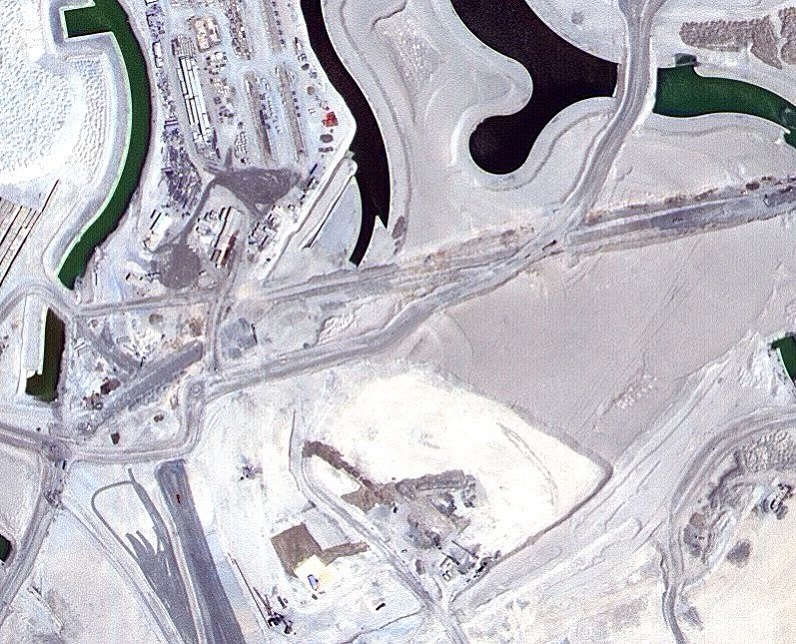

In [84]:
Image.open(r'Data\train\train\images\0.jpg')

In [85]:
np.array(Image.open(r'Data\train\train\images\0.jpg')).shape

(644, 796, 3)

# Path to images

In [86]:
image_filenames = sorted([os.path.join(train_dir, f) for f in os.listdir(train_dir) if f.endswith(('jpg', 'png'))]) # ['/content/train/images/0.jpg', ...]
mask_filenames = sorted([os.path.join(train_mask_dir, f) for f in os.listdir(train_mask_dir) if f.endswith(('jpg', 'png'))])

image_test_filenames = sorted([os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith(('jpg', 'png'))])
mask_test_filenames = sorted([os.path.join(test_mask_dir, f) for f in os.listdir(test_mask_dir) if f.endswith(('jpg', 'png'))])

# Функции перевода маски цветов в классы и обратно

In [87]:
palette = {
    0: (60, 16, 152),   # Building
    1: (132, 41, 246),  # Land
    2: (110, 193, 228), # Road
    3: (254, 221, 58),  # Vegetation
    4: (226, 169, 41),  # Water
    5: (155, 155, 155)  # Unlabeled
}

def color_to_label(mask, palette = palette):
    """
    Преобразует цветную маску (H, W, 4) в маску меток (H, W)
    на основе заданной палитры.
    """
    if mask.shape[-1] == 4:
        mask = mask[..., :3]

    # Инициализируем маску меток нулями
    label_mask = np.zeros(mask.shape[:2], dtype=np.uint8) # Создаем матрицу 0 идентично размеру маски (фотки)
    # Проходим по всем меткам и соответствующим им цветам
    for label, color in palette.items(): # Класс и цвет

        # Создаем булеву маску для пикселей, совпадающих с заданным цветом
        match = np.all(mask == color, axis=-1) # Сравнивает каждый пиксель маски с цветом (axis =-1, сравнивает каналы)
        """
        Проверим по пикселям (Пример):
        Для пикселя (0,0): [255, 0, 0] vs (0, 255, 0) → не совпадает → False.
        Для пикселя (0,1): [0, 255, 0] vs (0, 255, 0) → совпадает → True.
        Для пикселя (1,0): [255, 0, 0] vs (0, 255, 0) → не совпадает → False.
        Для пикселя (1,1): [0, 0, 255] vs (0, 255, 0) → не совпадает → False.
        """

        label_mask[match] = label # Булева маска заполняется классом (только там где True)
    return label_mask


def label_to_color(label_mask, palette):
    """
    Преобразует маску меток (H, W) в цветную маску (H, W, 3)
    на основе заданной палитры.
    """
    # Инициализируем цветную маску нулями
    color_mask = np.zeros((label_mask.shape[0], label_mask.shape[1], 3), dtype=np.uint8)
    # Назначаем каждому значению метки соответствующий цвет
    for label, color in palette.items():
        color_mask[label_mask == label] = color
    return color_mask

### Проверка маски на значения классов

[0 1 2 3 4 5]


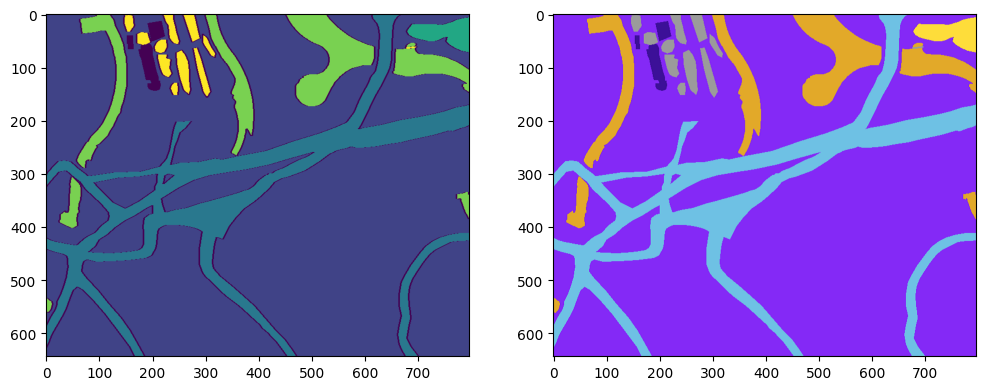

In [88]:
mask_color = np.array(Image.open(mask_filenames[0])) # Загружаем маску
mask_color = color_to_label(mask_color)

print(np.unique(mask_color)) # Check labels

fig, axs = plt.subplots(1, 2, figsize=(12, 7))

axs[0].imshow(mask_color)
axs[1].imshow(Image.open(mask_filenames[0]))

# Аугментация

In [89]:
import albumentations as A

# Геометрическая аугментация для изображений и масок (применяется к обоим)
geometric_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.RandomCrop(width=400, height=400, p=1.0),
    A.Resize(height=512, width=512)
], additional_targets={'mask': 'mask'})

# Цветовая аугментация для изображений (не применяется к маскам)
color_transform = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.ToGray(p=0.2),
    A.ToSepia(p=0.1)
])

def augment_image_and_mask(image, mask):
    """
    Применяет сначала геометрическую аугментацию к изображению и маске,
    затем цветовую аугментацию только к изображению.
    """
    image = image.numpy()
    mask = mask.numpy()

    # Применяем геометрическую аугментацию (применяется к обоим)
    augmented = geometric_transform(image=image, mask=mask)
    image_aug = augmented['image']
    mask_aug = augmented['mask']

    # Применяем цветовую аугментацию только к изображению
    image_aug = color_transform(image=image_aug)['image']

    return image_aug, mask_aug


# Определение функции для обработки данных в tf.data pipeline
def tf_process_data(image, mask):
    aug_image, aug_mask = tf.py_function(
        func=augment_image_and_mask,
        inp=[image, mask],
        Tout=[tf.float32, tf.uint8]
    )
    aug_image.set_shape([512, 512, 3])
    aug_mask.set_shape([512, 512, 1])
    return aug_image, aug_mask

# Dataset

In [90]:
def get_dataset(input_img_paths, mask_img_paths):

    def prepare_img(input_img_path, mask_img_path):

        img = tf.io.read_file(input_img_path)
        img = tf.io.decode_image(img, channels = 3)
        img.set_shape([None, None, 3])
        img = tf.image.resize(img, (512, 512), method="nearest")
        img = tf.image.convert_image_dtype(img, dtype = tf.float32)

        mask_bytes = tf.io.read_file(mask_img_path)
        mask = tf.io.decode_image(mask_bytes, channels=3)
        mask.set_shape([None, None, 3])
        mask = tf.image.resize(mask, (512, 512), method="nearest")
        # Применим функцию color_to_label через tf.py_function, поскольку она работает с numpy
        mask = tf.py_function(func=lambda m: color_to_label(np.array(m), palette),
                              inp=[mask],
                              Tout=tf.uint8)
        mask.set_shape([512, 512])  # После color_to_label ожидается двумерная маска
        mask = tf.expand_dims(mask, axis=-1)

        return img, mask

    dataset = tf.data.Dataset.from_tensor_slices((input_img_paths, mask_img_paths))
    dataset = dataset.map(prepare_img, num_parallel_calls=tf.data.AUTOTUNE)
    
    dataset = dataset.cache()
    
    dataset = dataset.repeat(75) # 600 изображений в эпохе
    dataset = dataset.shuffle(buffer_size = 700)
    dataset = dataset.map(tf_process_data, num_parallel_calls=tf.data.AUTOTUNE)

    # Предзагрузка данных для улучшения производительности
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset.batch(8)


dataset_train = get_dataset(image_filenames, mask_filenames)
dataset_test = get_dataset(image_test_filenames, mask_test_filenames)

In [91]:

for images, masks in dataset_test.take(1):
    print("Train images shape:", images.shape)
    print("Train masks shape:", masks.shape)


Train images shape: (8, 512, 512, 3)
Train masks shape: (8, 512, 512, 1)


# Метрики

In [92]:
def dice_coef(y_true, y_pred, smooth=1):
    num_classes = 6
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.one_hot(tf.squeeze(y_true, axis=-1), num_classes)
    y_pred = tf.cast(y_pred, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    union = tf.reduce_sum(y_true, axis=[1,2]) + tf.reduce_sum(y_pred, axis=[1,2])
    dice = tf.reduce_mean((2. * intersection + smooth) / (union + smooth), axis=-1)
    return dice

# Pretrained model

In [93]:
#!pip install segmentation-models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

import segmentation_models as sm
sm.set_framework('tf.keras')

BACKBONE = 'efficientnetb0'
preprocess_input = sm.get_preprocessing(BACKBONE)

model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=6, activation='softmax')

In [94]:
# Заморозим все слои, не относящиеся к декодеру
for layer in model.layers:
    if not (layer.name.startswith("decoder_stage") or layer.name in ['final_conv', 'softmax']):
        layer.trainable = False

In [95]:
for layer in model.layers:
    print(layer.name, layer.trainable)

input_layer_7 False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False
block2b_project_bn False
block2b_drop False
block2b_add False
block3a_expand_c

# Fit

In [96]:
"""
from keras.models import load_model

# Загружаем полную модель
model = load_model('model.h5')"
"""

'\nfrom keras.models import load_model\n\n# Загружаем полную модель\nmodel = load_model(\'model.h5\')"\n'

In [97]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Компиляция модели
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[dice_coef, 'accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=15, verbose=1),
    #ModelCheckpoint('model.h5', monitor='val_loss', save_best_only=True)
    ModelCheckpoint('model.weights.h5', monitor='val_dice_coef', save_best_only=True, save_weights_only=True)
]

# Обучение модели
history = model.fit(
    dataset_train,
    epochs=20,
    validation_data=dataset_test,
    callbacks=callbacks
)

Epoch 1/20
38/66 ━━━━━━━━━━━━━━━━━━━━ 1:52 4s/step - accuracy: 0.5673 - dice_coef: 0.2403 - loss: 1.2164

KeyboardInterrupt: 

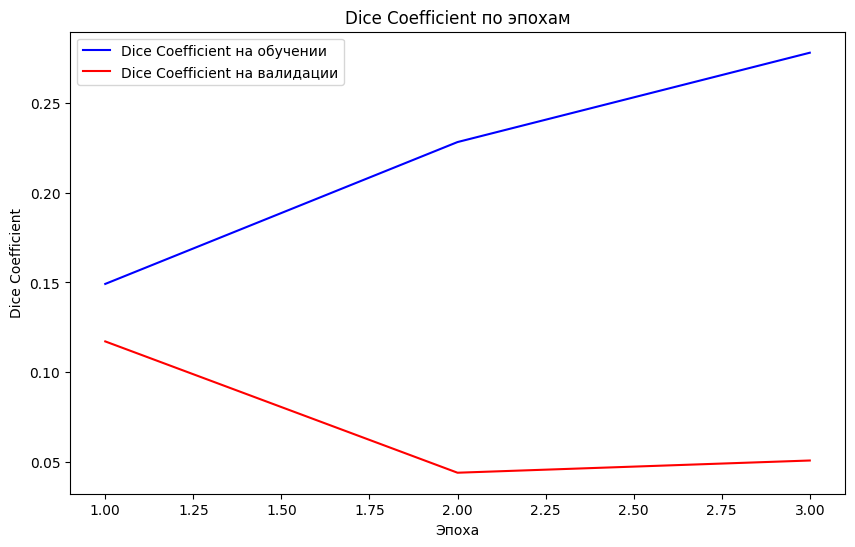

In [ ]:
import matplotlib.pyplot as plt

# Извлекаем значения метрики из объекта history
train_metric = history.history['dice_coef']
val_metric = history.history['val_dice_coef']
epochs = range(1, len(train_metric) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_metric, 'b', label='Dice Coefficient на обучении')
plt.plot(epochs, val_metric, 'r', label='Dice Coefficient на валидации')
plt.title('Dice Coefficient по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


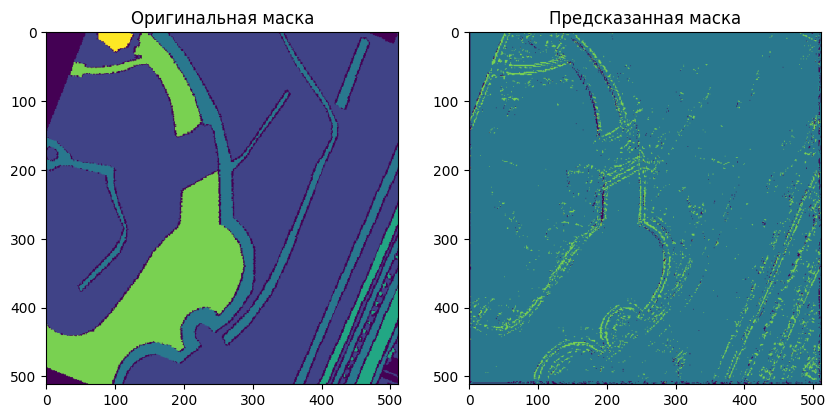

In [ ]:
for img, label in dataset_train.take(1):
    # Получаем предсказанную маску
    pred = model.predict(img)
    pred = np.argmax(pred, axis=-1)

    # Если оригинальная маска представлена в виде one-hot encoding, можно привести её к индексам:
    if label.shape[-1] > 1:
        original_mask = np.argmax(label, axis=-1)
    else:
        original_mask = label

    # Визуализация предсказанной и оригинальной маски
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_mask[0])
    plt.title("Оригинальная маска")

    plt.subplot(1, 2, 2)
    plt.imshow(pred[0])
    plt.title("Предсказанная маска")

    plt.show()
